In [2]:
import glob
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Detect the normal regions in the coranary
def detect_coronary_and_draw_mask(image, mask, pixel_value_range=(100, 300), alpha=0.4):
    # Ensure the mask is grayscale and matches the size of the image
    if len(mask.shape) == 3:  # Convert to grayscale if mask is in color
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    if mask.shape[:2] != image.shape[:2]:  # Resize if mask size does not match image size
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Restrict the pixel search to the provided mask
    masked_image = cv2.bitwise_and(gray_image, mask)

    # Threshold the image to isolate only pixels in the specified range
    range_mask = cv2.inRange(masked_image, pixel_value_range[0], pixel_value_range[1])

    # Create a red mask only for pixels in the specified range
    red_mask = np.zeros_like(image, dtype=np.uint8)
    red_mask[range_mask > 0] = (0, 0, 255)
    
    # The black-and-white mask will exactly match the detected pixels
    bw_mask = range_mask.copy()

    # Blend the red mask with the original image using alpha transparency
    # blended_image = cv2.addWeighted(image, 1, red_mask, alpha, 0)

    return image, bw_mask

# Detect the plaque regions in the coranary
def detect_plaques_and_draw_mask(image, mask, pixel_value_range=(20, 100), alpha=0.4):
    # Ensure the mask is grayscale and matches the size of the image
    if len(mask.shape) == 3:  # Convert to grayscale if mask is in color
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    if mask.shape[:2] != image.shape[:2]:  # Resize if mask size does not match image size
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Restrict the pixel search to the provided mask
    masked_image = cv2.bitwise_and(gray_image, mask)

    # Threshold the image to isolate only pixels in the specified range
    range_mask = cv2.inRange(masked_image, pixel_value_range[0], pixel_value_range[1])

    # Create a red mask only for pixels in the specified range
    red_mask = np.zeros_like(image, dtype=np.uint8)
    red_mask[range_mask > 0] = (0, 0, 255)
    
    # The black-and-white mask will exactly match the detected pixels
    bw_mask = range_mask.copy()

    # Blend the red mask with the original image using alpha transparency
    # blended_image = cv2.addWeighted(image, 1, red_mask, alpha, 0)

    return image, bw_mask

# Detect the outlines of plaques regions in the coranary
def detect_out_and_draw_mask(image, mask, pixel_value_range=(20, 100), thickness=15, alpha=0.4):
    # Ensure the mask is grayscale and matches the size of the image
    if len(mask.shape) == 3:  # Convert to grayscale if mask is in color
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    if mask.shape[:2] != image.shape[:2]:  # Resize if mask size does not match image size
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Restrict the pixel search to the provided mask
    masked_image = cv2.bitwise_and(gray_image, mask)

    # Threshold the image to isolate only pixels in the specified range
    range_mask = cv2.inRange(masked_image, pixel_value_range[0], pixel_value_range[1])

    # Find contours of the detected regions
    contours, _ = cv2.findContours(range_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a red mask only for the filtered pixels
    red_mask = np.zeros_like(image, dtype=np.uint8)
    bw_mask = np.zeros_like(range_mask)
    
    for contour in contours:
        # Create an empty mask for each contour
        contour_mask = np.zeros_like(range_mask)
        cv2.drawContours(contour_mask, [contour], -1, 255, thickness)
        
        # Keep only the pixels within the detected region
        filtered_mask = cv2.bitwise_and(range_mask, contour_mask)
        
        # Apply the filtered mask to create the red overlay
        red_mask[filtered_mask > 0] = (0, 0, 255)
        bw_mask[filtered_mask > 0] = 255

    return image, bw_mask

In [4]:
def average_images(image1, image2):
    # Check if both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same dimensions and number of channels")

    average_image = cv2.addWeighted(image1, 0.5, image2, 0.5, 0)

    return average_image

def threshold_image(image):
    # Create a new image where all pixels > 2 are set to 255 and others to 0
    thresholded_image = np.where(image > 10, 255, 0).astype(np.uint8)
    return thresholded_image

def find_first_and_last_255_in_each_row(image):
    # Ensure the image is in grayscale
    if len(image.shape) == 3:  # Check if the image is color (3 channels)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    # List to store the row number, first and last 255 pixel locations
    row_255_locations = []
    
    # Iterate over each row in the image
    for row in range(gray_image.shape[0]):
        # Find columns with 255 values in the current row
        cols_with_255 = np.where(gray_image[row] == 255)[0]
        
        # Check if there are any 255 values in this row
        if cols_with_255.size > 0:
            # First and last columns with 255 in the current row
            first_col = cols_with_255[0]
            last_col = cols_with_255[-1]
            
            # Append the row number, first and last column indices to the list
            row_255_locations.append([row, first_col, last_col])
    
    return row_255_locations

In [6]:
def remove_white_pixels(mask1, mask2):
    """
    Sets all white pixels (255) in mask1 to black (0) in mask2 at the same positions.
    
    Parameters:
        mask1 (numpy.ndarray): First binary mask.
        mask2 (numpy.ndarray): Second binary mask to be modified.
    
    Returns:
        numpy.ndarray: Modified mask2 with white pixels from mask1 set to black.
    """
    # Ensure both masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Both masks must have the same dimensions.")
    
    # Create a copy of mask2 to avoid modifying the original
    modified_mask2 = mask2.copy()
    
    # Set pixels to black in mask2 where mask1 is white
    modified_mask2[mask1 == 255] = 0
    
    return modified_mask2

In [7]:
paths = glob.glob("E:/coro. 1/final/*.jpg")

soft_images = []
soft_eq_images = []
mask_img = []
poses = []

for i in range(len(paths)):
    image = cv2.imread(paths[i])
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = average_images(image, img)
    
    # rotated = rotate_image_to_vertical(threshold_image(image), image)
    mask = threshold_image(image)
    pos = find_first_and_last_255_in_each_row(mask)
    soft_images.append(image)
    mask_img.append(mask)
    poses.append(pos)
    soft_eq_images.append(img)

In [8]:
avg_soft = []

for i in range(len(soft_eq_images)):
    img = average_images(soft_eq_images[i],soft_images[i])
    avg_soft.append(img)

In [9]:
n = 4

x, cor_msk = detect_coronary_and_draw_mask(avg_soft[n], mask_img[n])
x, plq_msk = detect_plaques_and_draw_mask(avg_soft[n], mask_img[n])
x, outlier = detect_out_and_draw_mask(avg_soft[n], mask_img[n],thickness=5)

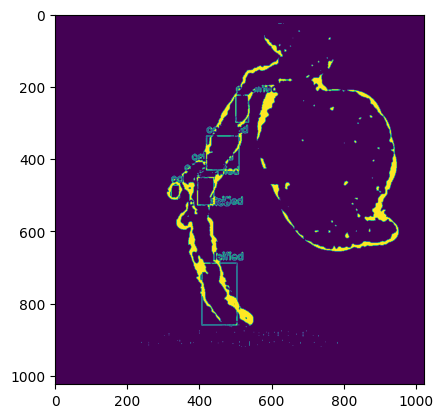

In [10]:
plt.imshow(plq_msk)

In [362]:
no_whitepix = remove_white_pixels(outlier, plq_msk)

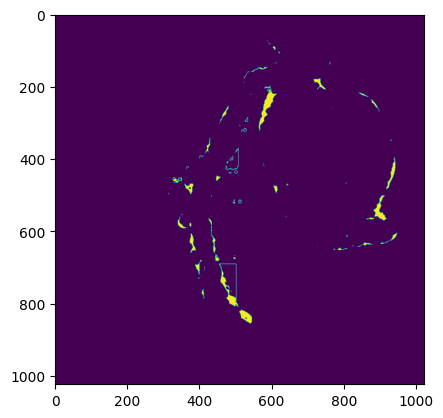

In [363]:
plt.imshow(no_whitepix)

In [412]:
def filter_regions_by_area(image, mask, area_threshold):
    """
    Filter regions by area without applying masks or bounding boxes.

    Args:
        image (np.ndarray): The original image.
        mask (np.ndarray): Binary mask with potential plaque regions.
        area_threshold (int): Minimum area size to keep a region.

    Returns:
        np.ndarray: The filtered image.
    """
    mask = (mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    filtered_mask = np.zeros_like(mask)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= area_threshold:
            cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    filtered_image = cv2.bitwise_and(image, image, mask=filtered_mask)
    return filtered_image


def apply_mask_and_bbox(original_image, filtered_image, small_threshold, large_threshold):
    """
    Apply a mask and bounding box on the detected regions with color-coded areas.

    Args:
        original_image (np.ndarray): The original image.
        filtered_image (np.ndarray): The image with filtered regions.
        small_threshold (int): Area threshold for small regions.
        large_threshold (int): Area threshold for large regions.

    Returns:
        np.ndarray: The image with masks, bounding boxes, and labels.
    """
    gray_filtered = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    mask = (gray_filtered > 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image = original_image.copy()
    overlay = original_image.copy()

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        
        if area >= large_threshold:
            color = (0, 0, 255)  # Red for large regions
            label = "soft"
        elif area >= small_threshold:
            color = (0, 255, 255)  # Yellow for medium regions
            label = "soft"
        else:
            color = (0, 255, 0)  # Green for small regions
            label = "soft"
        
        cv2.drawContours(overlay, [contour], -1, color, thickness=cv2.FILLED)
        cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)
        label_position = (x, y - 10)
        
        cv2.putText(output_image, f"{label}", label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,255), 2)
    
    cv2.addWeighted(overlay, 0.5, output_image, 0.8, 0, output_image)
    return output_image

In [395]:
# def filter_regions_by_area(image, mask, area_threshold):
#     """
#     Filter regions by area without applying masks or bounding boxes.

#     Args:
#         image (np.ndarray): The original image.
#         mask (np.ndarray): Binary mask with potential plaque regions.
#         area_threshold (int): Minimum area size to keep a region.

#     Returns:
#         np.ndarray: The filtered image.
#     """
#     # Ensure mask is binary
#     mask = (mask > 0).astype(np.uint8)
    
#     # Find contours
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     # Create an empty mask to draw valid regions
#     filtered_mask = np.zeros_like(mask)
    
#     for contour in contours:
#         area = cv2.contourArea(contour)
#         if area >= area_threshold:
#             cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
#     # Apply the filtered mask to the original image
#     filtered_image = cv2.bitwise_and(image, image, mask=filtered_mask)
    
#     return filtered_image

# def apply_mask_and_bbox(original_image, filtered_image):
#     """
#     Apply a mask and bounding box on the detected regions from the filtered image.

#     Args:
#         original_image (np.ndarray): The original image.
#         filtered_image (np.ndarray): The image with filtered regions.

#     Returns:
#         np.ndarray: The image with masks, bounding boxes, and labels.
#     """
#     gray_filtered = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
#     mask = (gray_filtered > 0).astype(np.uint8)
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     output_image = original_image.copy()
#     overlay = original_image.copy()
    
#     for contour in contours:
#         cv2.drawContours(overlay, [contour], -1, (0, 255, 255), thickness=cv2.FILLED)
#         x, y, w, h = cv2.boundingRect(contour)
#         cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 255), 2)
        
#         # Add the label "soft" above the bounding box
#         label_position = (x, y - 10)
#         cv2.putText(output_image, "soft", label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 130, 100), 3)
    
#     cv2.addWeighted(overlay, 0.5, output_image, 0.8, 0, output_image)
#     return output_image

In [415]:
for i in range(len(avg_soft)): 
# i += 1
    
    x, cor_msk = detect_coronary_and_draw_mask(avg_soft[i], mask_img[i])
    x, plq_msk = detect_plaques_and_draw_mask(avg_soft[i], mask_img[i])
    x, outlier = detect_out_and_draw_mask(avg_soft[i], mask_img[i],thickness=10)
    
    za = remove_white_pixels(outlier, plq_msk)
    
    mk = filter_regions_by_area(x,za,20)
    fnl = apply_mask_and_bbox(x, mk, 200, 500)
    cv2.imwrite(f'path/to/save/image.jpg', fnl)

# plt.imshow(fnl)

In [413]:
filtered_regions = filter_regions_by_area(x,no_whitepix,40)
final = apply_mask_and_bbox(x, filtered_regions,200,500)

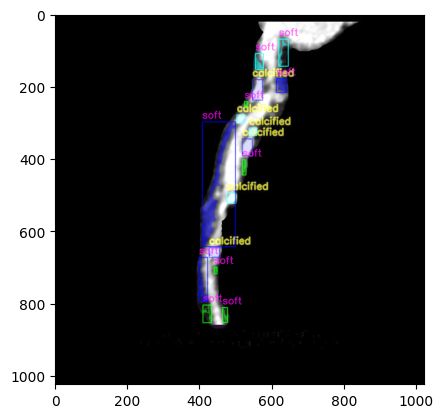

In [414]:
plt.imshow(final)